This notebook tries to see if there is more correlation between EEG to the same image rather than different images

In [2]:
from datasets import load_dataset

dataset = load_dataset("Alljoined/fulltest", cache_dir="/srv/eeg_reconstruction/shared")

/home/jonathan/mambaforge/envs/preprocessing/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def find_matching_in_block(dataset):
    seen_ids = {}

    for row in dataset:
        id = row["73k_id"]

        if id in seen_ids:
            return seen_ids[id], row
        
        seen_ids[id] = row
    
    return None, None # return none if none are matching

def find_nonmatching_in_block(dataset):
    block_data_list = list(dataset)

    found = False
    while not found:
        # Randomly select two different rows
        row1, row2 = random.sample(block_data_list, 2)
        found = row1['73k_id'] != row2['73k_id']

    return row1, row2

def corrcoef(row1, row2):
    eeg1 = row1["EEG"]
    eeg2 = row2["EEG"]
    return np.array([np.corrcoef(eeg1[i], eeg2[i])[0, 1] for i in range(64)])


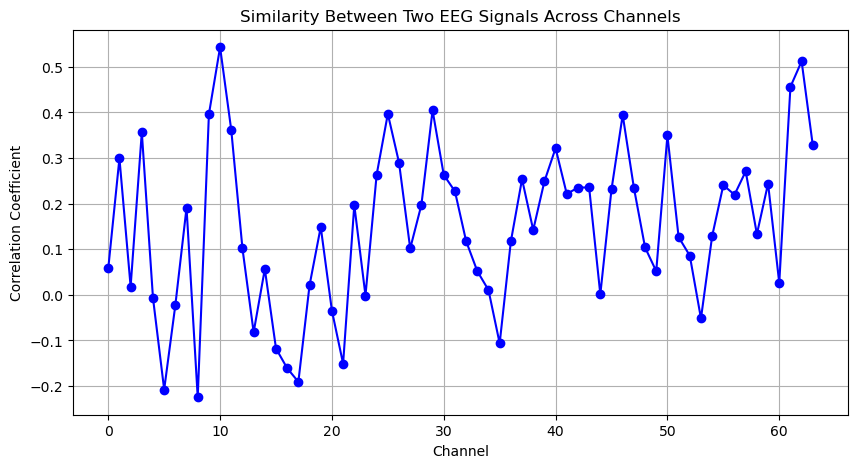

Average similarity across all channels: 0.15


In [5]:
block_id = 1
train_dataset = dataset['train']
subset = train_dataset.filter(lambda x: x["block"] == block_id)
# Shuffle the dataset
subset = subset.shuffle(seed=42)

# Get similarities
same1, same2 = find_matching_in_block(subset)
similarities = corrcoef(same1, same2)
# Average similarity
average_similarity = np.mean(similarities)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(similarities, marker='o', linestyle='-', color='b')
plt.title('Similarity Between Two EEG Signals Across Channels')
plt.xlabel('Channel')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

print(f"Average similarity across all channels: {average_similarity:.2f}")

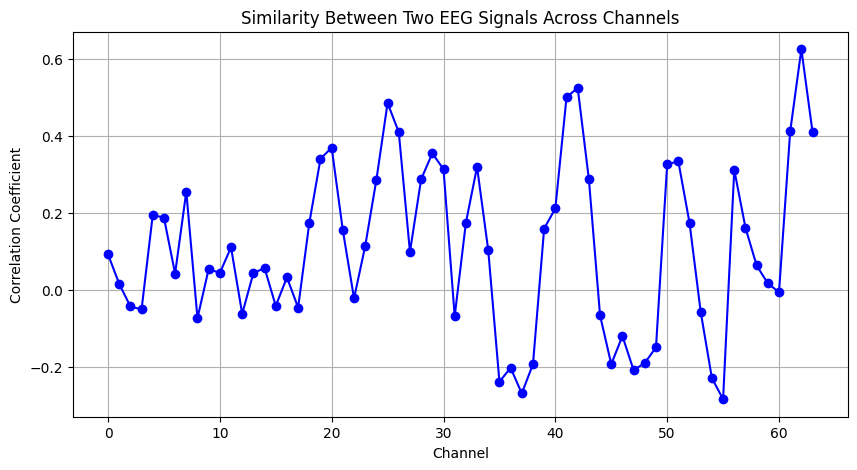

Average similarity across all channels: 0.11


In [7]:
# Get similarities
diff1, diff2 = find_nonmatching_in_block(subset)
similarities = corrcoef(diff1, diff2)
# Average similarity
average_similarity = np.mean(similarities)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(similarities, marker='o', linestyle='-', color='b')
plt.title('Similarity Between Two EEG Signals Across Channels')
plt.xlabel('Channel')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

print(f"Average similarity across all channels: {average_similarity:.2f}")

# Correlation coefficient

In [6]:
from itertools import combinations, product

def generate_pairs(dataset):
    same_id_pairs = []
    different_id_pairs = []

    # Organize data by 73k_id
    id_dict = {}
    for data in dataset:
        if data['73k_id'] in id_dict:
            id_dict[data['73k_id']].append(data)
        else:
            id_dict[data['73k_id']] = [data]

    # Generate same 73k_id pairs
    for key, values in id_dict.items():
        if len(values) > 1:
            for pair in combinations(values, 2):
                same_id_pairs.append(pair)

    # Generate different 73k_id pairs
    # Iterate over pairs of different keys
    for key1, key2 in combinations(id_dict.keys(), 2):
        pair = (id_dict[key1][0], id_dict[key2][0])
        different_id_pairs.append(pair)
        if len(different_id_pairs) == len(same_id_pairs):
            break

    return same_id_pairs, different_id_pairs

def calculate_correlations(pairs):
    correlations = []
    for row1, row2 in pairs:
        correlation = corrcoef(row1, row2)
        correlations.append(correlation)
    return correlations


In [37]:
matching_correlations = []
nonmatching_correlations = []

# Assuming 'dataset' is a list of dictionaries and 'block' is a valid key
same_id_pairs, different_id_pairs = generate_pairs(subset)


matching_correlations.extend(calculate_correlations(same_id_pairs))
nonmatching_correlations.extend(calculate_correlations(different_id_pairs))


T-statistic: -0.5822323112676551, P-value: 0.5611413785303734


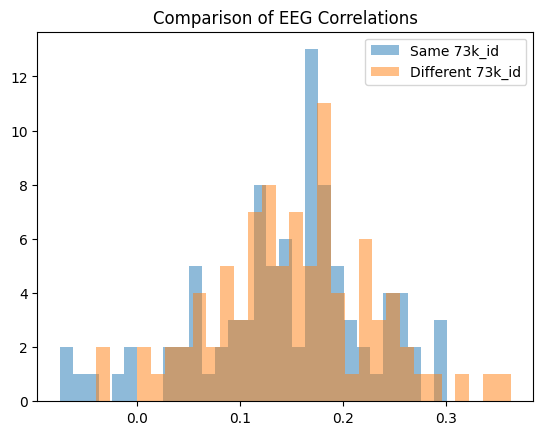

In [39]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Example of T-test
t_stat, p_value = ttest_ind([np.mean(corr) for corr in matching_correlations],
                            [np.mean(corr) for corr in nonmatching_correlations], equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting histograms
plt.hist([np.mean(corr) for corr in matching_correlations], bins=30, alpha=0.5, label='Same 73k_id')
plt.hist([np.mean(corr) for corr in nonmatching_correlations], bins=30, alpha=0.5, label='Different 73k_id')
plt.legend()
plt.title('Comparison of EEG Correlations')
plt.show()


# Coherence

T-statistic: 0.19074001652085312, P-value: 0.848949727842798


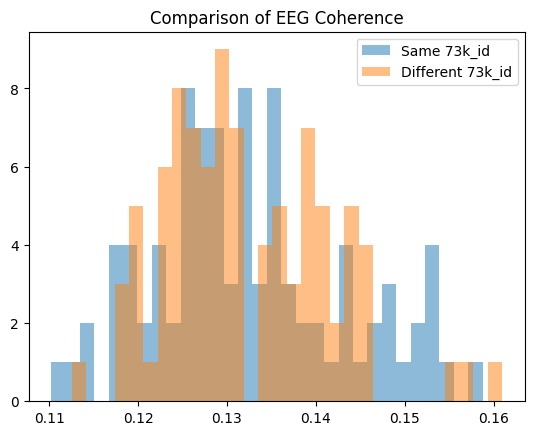

In [46]:
from scipy.signal import coherence

# Assuming 'same_id_pairs' and 'different_id_pairs' are lists of tuples,
# where each tuple contains two numpy arrays representing EEG data from two channels.

def calculate_coherence(pairs):
    coherence_values = []
    for (row1, row2) in pairs:
        data1 = row1["EEG"]
        data2 = row2["EEG"]
        f, Cxy = coherence(data1, data2, fs=512, nperseg=64)  # Adjust fs and nperseg according to your dataset
        mean_coherence = np.mean(Cxy)
        coherence_values.append(mean_coherence)
    return coherence_values

# Calculate coherence for matching and nonmatching pairs
matching_coherence = calculate_coherence(same_id_pairs)
nonmatching_coherence = calculate_coherence(different_id_pairs)

# Perform T-test on the mean coherence values
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(matching_coherence, nonmatching_coherence, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting histograms of coherence values
plt.hist(matching_coherence, bins=30, alpha=0.5, label='Same 73k_id')
plt.hist(nonmatching_coherence, bins=30, alpha=0.5, label='Different 73k_id')
plt.legend()
plt.title('Comparison of EEG Coherence')
plt.show()


# Dynamic Time Warping

DTW T-statistic: 4.119519381165006, DTW P-value: 5.8364487989502416e-05


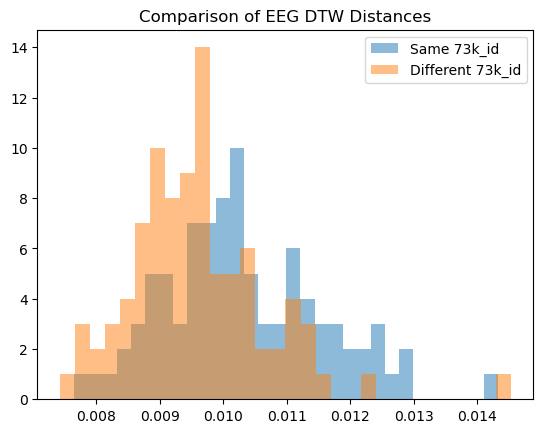

In [7]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Function to calculate DTW distance between pairs
def calculate_dtw(pairs):
    dtw_distances = []
    for (row1, row2) in pairs:
        data1 = row1["EEG"]
        data2 = row2["EEG"]
        distance, path = fastdtw(data1, data2, dist=euclidean)
        dtw_distances.append(distance)
    return dtw_distances

# Generate pairs of EEG signals
same_id_pairs, different_id_pairs = generate_pairs(subset)

# Calculate DTW distances
matching_dtw_distances = calculate_dtw(same_id_pairs)
nonmatching_dtw_distances = calculate_dtw(different_id_pairs)

# Example of T-test on DTW distances
from scipy.stats import ttest_ind
t_stat_dtw, p_value_dtw = ttest_ind(matching_dtw_distances, nonmatching_dtw_distances, equal_var=False)
print(f"DTW T-statistic: {t_stat_dtw}, DTW P-value: {p_value_dtw}")

# Plotting histograms for DTW distances
import matplotlib.pyplot as plt
plt.hist(matching_dtw_distances, bins=30, alpha=0.5, label='Same 73k_id')
plt.hist(nonmatching_dtw_distances, bins=30, alpha=0.5, label='Different 73k_id')
plt.legend()
plt.title('Comparison of EEG DTW Distances')
plt.show()


In [12]:
print(same_id_pairs[1][0]["73k_id"], same_id_pairs[1][1]["73k_id"])

2950 2950


In [13]:
print(different_id_pairs[1][0]["73k_id"], different_id_pairs[1][1]["73k_id"])

5106 9865
